In [1]:
"""
2025/07/21 Using the PINN loss function to solve the Neumann boundary value problem 
-\lap u + u = f in \Omega,
u = 0 on \partial\Omega, 
\Omega = (0,1) x (0,1) 

Exact solution: u = \sin(\pi x1)\sin(\pi x2)
f = (\pi^2 + 1)\sin(\pi x1)\sin(\pi x2)
author: Xiaofeng Xu 

log: July 25th Make the code dimension dependent 
"""
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi)
ZERO = torch.tensor([0.]).to(device)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            ## ZERO = torch.tensor([0.]).to(device)
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1
    def evaluate_2ndderivative(self,x,i,j): 
        if self.k == 2:
            u1 = self.fc2( 2 * torch.heaviside(self.fc1(x),ZERO) * (self.fc1.weight.t()[i-1:i,:])*self.fc1.weight.t()[j-1:j,:]) 
        else:
            u1 = self.fc2( self.k*(self.k-1)*F.relu(self.fc1(x))**(self.k-2) * (self.fc1.weight.t()[i-1:i,:])* (self.fc1.weight.t()[j-1:j,:]))  
        return u1
    
def plot_2D(f): 
    
    Nx = 400
    Ny = 400 
    xs = np.linspace(0, 1, Nx)
    ys = np.linspace(0, 1, Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    xy_comb = np.stack((x.flatten(),y.flatten())).T
    xy_comb = torch.tensor(xy_comb)
    z = f(xy_comb).reshape(Nx,Ny)
    z = z.detach().numpy()
    plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x , y , z )

    plt.show()

def plot_subdomains(my_model):
    x_coord =torch.linspace(0,1,200)
    wi = my_model.fc1.weight.data
    bi = my_model.fc1.bias.data 
    for i, bias in enumerate(bi):  
        if wi[i,1] !=0: 
            plt.plot(x_coord, - wi[i,0]/wi[i,1]*x_coord - bias/wi[i,1])
        else: 
            plt.plot(x_coord,  - bias/wi[i,0]*torch.ones(x_coord.size()))

    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.show()
    return 0   


In [2]:
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    x_r: float
    right endpoint of an interval 
    Nx: int 
    number of subintervals for integration
    order: int
    order of Gauss Quadrature 
    Returns
    -------
    vectorized quadrature weights and integration points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    x_model_pt = x_model_pt[x_model_pt>=r1].reshape(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    # plt.plot(x_model_pt.cpu(),u_model_pt.cpu(),'.r')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()

def plot_2D(f): 
    
    Nx = 400
    Ny = 400 
    xs = np.linspace(0, 1, Nx)
    ys = np.linspace(0, 1, Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    xy_comb = np.stack((x.flatten(),y.flatten())).T
    xy_comb = torch.tensor(xy_comb)
    z = f(xy_comb).reshape(Nx,Ny)
    z = z.detach().numpy()
    plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x , y , z )

    plt.show()

def PiecewiseGQ2D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """

#     print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1).T
    weights =  (w*w[:,None]).ravel()

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**2,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**2 /4 

    integration_points = torch.tile(gauss_pts,(Nx**2,1))
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(2,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**2)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,2)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 
#     print(integration_points.size())
    # func_values = integrand2_torch(integration_points)
    return long_weights, integration_points

def Neumann_boundary_quadrature_points_weights(M,d):
    def generate_quadpts_on_boundary(gw_expand_bd, integration_points_bd,d):
        size_pts_bd = integration_points_bd.size(0) 
        gw_expand_bd_faces = torch.tile(gw_expand_bd,(2*d,1)) # 2d boundaries, 拉成长条

        integration_points_bd_faces = torch.zeros(2*d*integration_points_bd.size(0),d).to(device)
        for ind in range(d): 
            integration_points_bd_faces[2 *ind * size_pts_bd :(2 *ind +1) * size_pts_bd,ind:ind+1] = 0 
            integration_points_bd_faces[(2 *ind)*size_pts_bd :(2 * ind +1) * size_pts_bd,:ind] = integration_points_bd[:,:ind]
            integration_points_bd_faces[(2 *ind)*size_pts_bd :(2 * ind +1) * size_pts_bd,ind+1:] = integration_points_bd[:,ind:]

            integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,ind:ind+1] = 1
            integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,:ind] = integration_points_bd[:,:ind]        
            integration_points_bd_faces[(2 *ind +1) * size_pts_bd:(2 *ind +2)*size_pts_bd,ind+1:] = integration_points_bd[:,ind:]
        return gw_expand_bd_faces, integration_points_bd_faces
    
    if d == 1: 
        print('dim',d)
        gw_expand_bd_faces = torch.tensor([1.,1.]).view(-1,1).to(device)
        integration_points_bd_faces = torch.tensor([0.,1.]).view(-1,1).to(device) 
    elif d == 2: 
        print('dim',d)
        gw_expand_bd, integration_points_bd = PiecewiseGQ1D_weights_points(0,1,1024, order = 3) 
    elif d == 3: 
        gw_expand_bd, integration_points_bd = PiecewiseGQ2D_weights_points(200, order = 3) 
    elif d == 4: 
        gw_expand_bd, integration_points_bd = PiecewiseGQ3D_weights_points(25, order = 3) 
        print('dim',d)
    else: 
        gw_expand_bd, integration_points_bd = MonteCarlo_Sobol_dDim_weights_points(M ,d = d-1)
        print('dim >=5 ')
    if d != 1: 
        gw_expand_bd_faces, integration_points_bd_faces = generate_quadpts_on_boundary(gw_expand_bd, integration_points_bd,d)
    return gw_expand_bd_faces.to(device), integration_points_bd_faces.to(device) 


def show_convergence_order2_PINN(err_l2,err_h10,err_energy, exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    err_list3 = [err_energy[i] for i in neuron_nums ]
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \t\t order  \t\t energy err \t\t order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")s
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.3e} \t\t * \t\t {:.3e} \t\t * \t\t {:.3e} \t\t * \n".format(neuron_nums[i],item, err_list2[i],err_list3[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t *  \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i],err_list3[i] ))
        else: 
            print("{} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f}  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2), 
                                                                            err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2),
                                                                             err_list3[i] , np.log(err_list3[i-1]/err_list3[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2),err_list3[i] , np.log(err_list3[i-1]/err_list3[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex2(err_l2,err_h10,exponent,k=1,d=1): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    l2_order = -1/2-(2*k + 1)/(2*d)
    h1_order =  -1/2-(2*(k-1)+ 1)/(2*d)
    print("neuron num  & \t $\|u-u_n \|_{{L^2}}$ & \t order $O(n^{{{:.2f}}})$  & \t $ | u -u_n |_{{H^1}}$ & \t order $O(n^{{{:.2f}}})$  \\\ \hline \hline ".format(l2_order,h1_order))
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
        else: 
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )




In [3]:
def minimize_linear_layer_PINN_neumann(model,target,weights, integration_points,weights_bd, integration_points_bd, g_D, activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    dim = integration_points.size(1)  # dimension of the problem 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_bd_col = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
    weighted_basis_value_bd_col = basis_value_bd_col * weights_bd
    jac2 = weighted_basis_value_bd_col.t() @ (basis_value_bd_col)  # (u,v)_{\partial \Omega}

    # (Lu, Lv)_{\Omega} 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    if activation == 'relu':

        if model.k == 1:
            assert False, "k must be at least 2"
        if model.k == 2:  
            for ii in range(dim): 
                if ii == 0: 
                    L_basis_col = basis_value_col  - 2 * torch.heaviside(integration_points @ w.t()+ b, ZERO) * (w.t()[ii:ii+1,:])**2 
                else: 
                    L_basis_col -= 2 * torch.heaviside(integration_points @ w.t()+ b, ZERO) * (w.t()[ii:ii+1,:])**2
            # basis_value_d11_col = 2 * torch.heaviside(integration_points @ w.t()+ b, ZERO) * (w.t()[0:1,:])**2 
            # L_basis_col = - basis_value_d11_col + basis_value_col 
        else: 
            for ii in range(dim): 
                if ii == 0: 
                    L_basis_col = basis_value_col  - model.k * (model.k -1) * F.relu(integration_points @ w.t()+ b)**(model.k-2) * (w.t()[ii:ii+1,:])**2 
                else: 
                    L_basis_col -= model.k * (model.k -1) * F.relu(integration_points @ w.t()+ b)**(model.k-2) * (w.t()[ii:ii+1,:])**2
            # basis_value_d11_col = model.k * (model.k -1) * F.relu(integration_points @ w.t()+ b)**(model.k-2) * (w.t()[0:1,:])**2 
            # L_basis_col = - basis_value_d11_col + basis_value_col 
        weighted_L_basis_col = L_basis_col * weights 
    jac1 =  weighted_L_basis_col.t() @L_basis_col 
    jac = jac1 + jac2

    rhs1 = weighted_L_basis_col.t() @ (target(integration_points) )

    # Dirichlet boundary (g,v)_{\partial \Omega}, g = 0 
    rhs2 = weighted_basis_value_bd_col.t() @ g_D(integration_points_bd) 

    rhs = rhs1 + rhs2 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    ## update the solution 
    return sol 

In [4]:
def compute_gradient_error(u_exact_grad,my_model,M,batch_size_2,weights,integration_points):
    """
    Parameters
    ----------
    u_exact_grad: list or None
        a list that contains ways of evaluating partial derivatives that gives the gradient  
    """
    err_h10 = 0 
     # initial gradient error 
    if u_exact_grad != None and my_model!=None:
        u_grad = u_exact_grad() 
        for ii, grad_i in enumerate(u_grad): 
            for jj in range(0,M,batch_size_2): 
                end_index = jj + batch_size_2 
                my_model_dxi = my_model.evaluate_derivative(integration_points[jj:end_index,:],ii+1).detach() 
                err_h10 += torch.sum((grad_i(integration_points[jj:end_index,:]) - my_model_dxi)**2 * weights[jj:end_index,:])
    elif u_exact_grad != None and my_model==None:
        u_grad = u_exact_grad() 
        for grad_i in u_grad: 
            for jj in range(0,M,batch_size_2): 
                end_index = jj + batch_size_2 
                err_h10 += torch.sum((grad_i(integration_points[jj:end_index,:]))**2 * weights[jj:end_index,:])
    return err_h10**0.5

In [7]:
def generate_relu_dict4plusD_sphere(dim, s,N0): 
    samples = torch.randn(s*N0,dim +1) 
    samples = samples/samples.norm(dim=1,keepdim=True)  
    Wb = samples 
    return Wb 

def generate_relu_dict2D(N_list):
    N1 = N_list[0] 
    N2 = N_list[1]
    
    theta = np.linspace(0, 2*pi, N1, endpoint= False).reshape(N1,1)
    W1 = np.cos(theta)
    W2 = np.sin(theta)
    W = np.concatenate((W1,W2),1) # N1 x 2
    b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1)
    
    index1 = np.arange(N1)
    index2 = np.arange(N2)
    ordered_pairs = np.array(np.meshgrid(index1,index2,indexing='ij'))

    ordered_pairs = ordered_pairs.reshape(2,-1).T
    W = W[ordered_pairs[:,0],:]
    b = b[ordered_pairs[:,1],:]
    Wb = np.concatenate((W,b),1) # N1 x 3 
    Wb_tensor = torch.from_numpy(Wb) 
    return Wb_tensor


#2 TODO Make this compatible with dimension  
def select_greedy_neuron_ind(relu_dict_parameters,my_model,target,weights, integration_points,g_D,weights_bd, integration_points_bd,k): 

    dim = integration_points.size(1) 
    residual_values = - target(integration_points)
    if my_model!= None:
        residual_values +=  my_model(integration_points).detach() 
        for ii in range(dim):
             residual_values -= my_model.evaluate_2ndderivative(integration_points,ii+1,ii+1).detach() 

    weight_residual_values = residual_values*weights # 1. weights * ( Lu - f ) 

    basis_values = (F.relu(integration_points @ (relu_dict_parameters[:,0:dim].T) - relu_dict_parameters[:,dim])**k) # uses broadcasting
    # output1 = torch.matmul(basis_values,weight_func_values) # 

    # ============TODO 
    # L (basis values)
    if k == 1:
        assert k>=2, "k must be at least 2"
    elif k == 2:  
        for ii in range(dim): 
            if ii == 0: 
                Lg = basis_values - 2 * torch.heaviside(integration_points @ (relu_dict_parameters[:,0:dim].T) - relu_dict_parameters[:,dim], ZERO) * (relu_dict_parameters.t()[ii:ii+1,:])**2 
            else: 
                Lg -= 2 * torch.heaviside(integration_points @ (relu_dict_parameters[:,0:dim].T) - relu_dict_parameters[:,dim], ZERO) * (relu_dict_parameters.t()[ii:ii+1,:])**2 
        # dbasis_values_d11 =  2 * torch.heaviside(integration_points @ (relu_dict_parameters[:,0:dim].T) - relu_dict_parameters[:,dim], ZERO) * (relu_dict_parameters.t()[0:1,:])**2 
        # Lg = - dbasis_values_d11 + basis_values
    else:  
        for ii in range(dim): 
            if ii == 0: 
                Lg = basis_values - k * (k-1) * F.relu(integration_points @ (relu_dict_parameters[:,0:dim].T) - relu_dict_parameters[:,dim])**(k-2) * (relu_dict_parameters.t()[ii:ii+1,:])**2
            else: 
                Lg -= k * (k-1) * F.relu(integration_points @ (relu_dict_parameters[:,0:dim].T) - relu_dict_parameters[:,dim])**(k-2) * (relu_dict_parameters.t()[ii:ii+1,:])**2
        # dbasis_values_d11 = k *(k-1) * F.relu(integration_points @ (relu_dict_parameters[:,0:dim].T) - relu_dict_parameters[:,1])**(k-2) * (relu_dict_parameters.t()[0:1,:])**2  
        # Lg = - dbasis_values_d11 + basis_values 
    output2 = torch.matmul(Lg.t(), weight_residual_values) 
    #============TODO===========

    # Dirichlet boundary condition # 3. (u^{n-1},g)_{\partial \Omega}
    basis_values_bd_col = (F.relu(integration_points_bd  @ relu_dict_parameters[:,0:dim].T - relu_dict_parameters[:,dim])**k) 
    weighted_basis_value_col_bd = basis_values_bd_col * weights_bd

    # dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device):

    if my_model!= None:
        u_n_1 = my_model(integration_points_bd).detach() 
        g_bd = g_D(integration_points_bd)  
        output3 =  weighted_basis_value_col_bd.t() @ (u_n_1 - g_bd)
        output = torch.abs(output2 + output3)
    else:
        g_bd = g_D(integration_points_bd)   
        output3 =  weighted_basis_value_col_bd.t() @ (- g_bd)
        output = torch.abs(output2 + output3)
    neuron_index = torch.argmax(output.flatten())
    
    return neuron_index 

def OGANeumannPINNReLU2D(my_model,target,u_exact,u_exact_grad,g_D, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1,rand_deter = 'deter', solver = 'direct'): 
    """ Orthogonal greedy algorithm to solve a 1D Neumann problem 1D ReLU dictionary over [0,1]
    """
    dim = 2 
    integration_weights, integration_points = PiecewiseGQ2D_weights_points(Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points_weights(M = 2,d= dim) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    err_energy = torch.zeros(num_epochs+1) # added 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        integration_weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(integration_weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*integration_weights)**0.5
    if my_model!= None:
        # err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*integration_weights)**0.5
        err_h10[0] = compute_gradient_error(u_exact_grad,my_model,integration_points.size(0),integration_points.size(0),integration_weights,integration_points)
        ## TODO 
        Lu = my_model(integration_points).detach()  
        for ii in range(dim): 
            Lu -= my_model.evaluate_2ndderivative(integration_points,ii+1,ii+1).detach()
        energy  = 0.5 * integration_weights.t() @ ( Lu - target(integration_points) ) **2  + 0.5 * weights_bd.t() @ (my_model(integration_points_bd).detach()- g_D(integration_points_bd))**2  # added  
        err_energy[0] = energy  
    else: 
        # todo 
        err_h10[0] = compute_gradient_error(u_exact_grad,my_model,integration_points.size(0),integration_points.size(0),integration_weights,integration_points)
        ## TODO  
        energy  = 0.5 * integration_weights.t() @ target(integration_points)**2 + 0.5 * weights_bd.t() @ (g_D(integration_points_bd))**2   # add boundary energy 1/2 \int |u-g|^2 ds  # added  
        err_energy[0] = energy 

    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    # if rand_deter == 'deter': 
    #     relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        print('epoch: ',i+1)
        if rand_deter == 'rand': 
            relu_dict_parameters = generate_relu_dict4plusD_sphere(dim, 1, N) # 100 samples, 2D 
        # start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind(relu_dict_parameters,my_model,target,integration_weights, integration_points,g_D,weights_bd, integration_points_bd, k) 
        # print("argmax time: ", time.time() - start_argmax) 
        # print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0:dim])
        list_b.append(-relu_dict_parameters[neuron_index,dim]) # different sign convention 
        num_neuron += 1
        my_model = model(dim,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0)  
        my_model.fc1.weight.data[:,0:dim] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]

        sol = minimize_linear_layer_PINN_neumann(my_model,target,integration_weights, integration_points,weights_bd, integration_points_bd,g_D,activation ='relu', solver = solver)
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            ## TODO DONE 
            plot_2D(my_model.cpu())
            
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*integration_weights)**0.5
        err_h10[i+1] = compute_gradient_error(u_exact_grad,my_model,integration_points.size(0),integration_points.size(0),integration_weights,integration_points)
        ## TODO 
        Lu = my_model(integration_points).detach()  
        for ii in range(dim): 
            Lu -= my_model.evaluate_2ndderivative(integration_points,ii+1,ii+1).detach()
        energy  = 0.5 * integration_weights.t() @ ( Lu - target(integration_points) )**2 + 0.5 * weights_bd.t() @ (my_model(integration_points_bd).detach()- g_D(integration_points_bd))**2   # added  
        err_energy[i+1] = energy  
    print("time taken: ",time.time() - start_time)
    return err, err_h10,err_energy, my_model


## randomized dictionary 

### sine example 

dim 2
using linear solver:  direct
epoch:  1
assembling the matrix time taken:  0.0006248950958251953
solving Ax = b time taken:  0.004136800765991211
epoch:  2
assembling the matrix time taken:  0.0018911361694335938
solving Ax = b time taken:  0.0006330013275146484
epoch:  3
assembling the matrix time taken:  0.0014460086822509766
solving Ax = b time taken:  7.414817810058594e-05
epoch:  4
assembling the matrix time taken:  0.002028942108154297
solving Ax = b time taken:  0.0001881122589111328
epoch:  5
assembling the matrix time taken:  0.002373933792114258
solving Ax = b time taken:  7.295608520507812e-05
epoch:  6
assembling the matrix time taken:  0.0022580623626708984
solving Ax = b time taken:  0.0003108978271484375
epoch:  7
assembling the matrix time taken:  0.002657651901245117
solving Ax = b time taken:  7.009506225585938e-05
epoch:  8
assembling the matrix time taken:  0.0020411014556884766
solving Ax = b time taken:  0.00021576881408691406
epoch:  9
assembling the matrix 

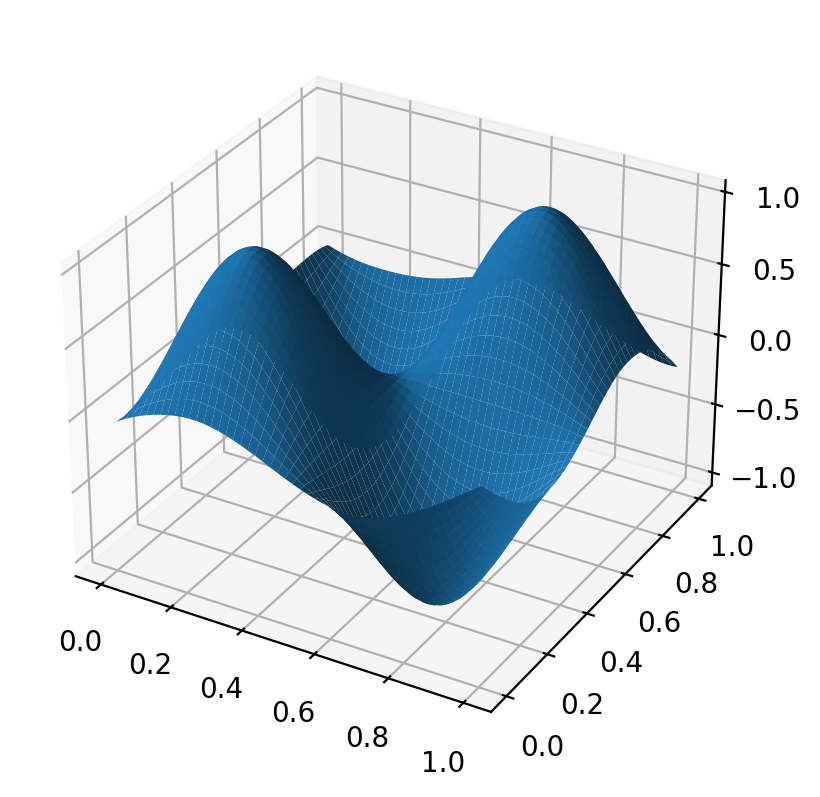

time taken:  8.338454723358154
neuron num 		 error 		 order
4 		 3.178e+00 		 * 		 1.366e+01 		 * 		 5.647e+02 		 * 

8 		 1.644e+00 		 0.95 		 8.289e+00 		 0.72 		 3.688e+02 		 0.61  

16 		 3.105e-01 		 2.40 		 3.278e+00 		 1.34 		 5.334e+01 		 2.79  

32 		 2.025e-01 		 0.62 		 2.555e+00 		 0.36 		 9.196e+00 		 2.54  

64 		 4.901e-02 		 2.05 		 6.060e-01 		 2.08 		 9.101e-01 		 3.34  



/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_1200/3057554446.py:184: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print("{} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f}  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_1200/3057554446.py:185: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_1200/3057554446.py:186: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list3[i] , np.log(err_list3[i-1]/err_list3[i])/np.log(2) ) )
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ip

In [8]:
m1 = 2
m2 = 2  
def u_exact(x):
    return torch.sin(m1 * pi*x[:,0:1])*torch.sin(m2 * pi*x[:,1:2]) 

def u_exact_grad(): 
    def grad_1(x):
        return  m1*pi* torch.cos(m1*pi*x[:,0:1])*torch.sin( m2*pi*x[:,1:2]) 
    def grad_2(x):
        return  m2*pi* torch.sin(m1*pi*x[:,0:1])*torch.cos( m2*pi*x[:,1:2]) 

    u_grad=[grad_1, grad_2] 

    return u_grad

def rhs(x):
    z = ( (m1*pi)**2 + (m2*pi)**2 + 1)*torch.sin(m1 * pi*x[:,0:1])*torch.sin(m2  * pi*x[:,1:2] )
    return z 


dim = 2  
function_name = "sinpix2d" 
filename_write = "data/2DOGA-{}-order.txt".format(function_name)
Nx = 50  
order = 2  
f_write = open(filename_write, "a")
f_write.write("Integration points: Nx {}, order {} \n".format(Nx,order))
f_write.close() 

save = False 
write2file = True
rand_deter = 'rand'
for N in [2**10]: # 2**12,2**14
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 6 
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    relu_k = 3     
    err_QMC2, err_h10, err_energy, my_model = OGANeumannPINNReLU2D(None,rhs,u_exact,u_exact_grad,u_exact, N,num_epochs,plot_freq, Nx, order, k =relu_k, rand_deter = rand_deter,solver = "direct")

    if save: 
        folder = 'data/'
        filename = folder + 'err_NeumannOGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_NeumannOGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    show_convergence_order2_PINN(err_QMC2,err_h10,err_energy, exponent,2*N,filename_write,write2file = write2file)



### cosine example 

dim 2
using linear solver:  direct
epoch:  1
assembling the matrix time taken:  0.0008749961853027344
solving Ax = b time taken:  9.393692016601562e-05
epoch:  2
assembling the matrix time taken:  0.0010471343994140625
solving Ax = b time taken:  0.00021505355834960938
epoch:  3
assembling the matrix time taken:  0.0013279914855957031
solving Ax = b time taken:  6.794929504394531e-05
epoch:  4
assembling the matrix time taken:  0.002974271774291992
solving Ax = b time taken:  0.00020194053649902344
epoch:  5
assembling the matrix time taken:  0.0021440982818603516
solving Ax = b time taken:  7.987022399902344e-05
epoch:  6
assembling the matrix time taken:  0.003556966781616211
solving Ax = b time taken:  0.00016999244689941406
epoch:  7
assembling the matrix time taken:  0.002637147903442383
solving Ax = b time taken:  6.985664367675781e-05
epoch:  8
assembling the matrix time taken:  0.0021409988403320312
solving Ax = b time taken:  0.00020194053649902344
epoch:  9
assembling the mat

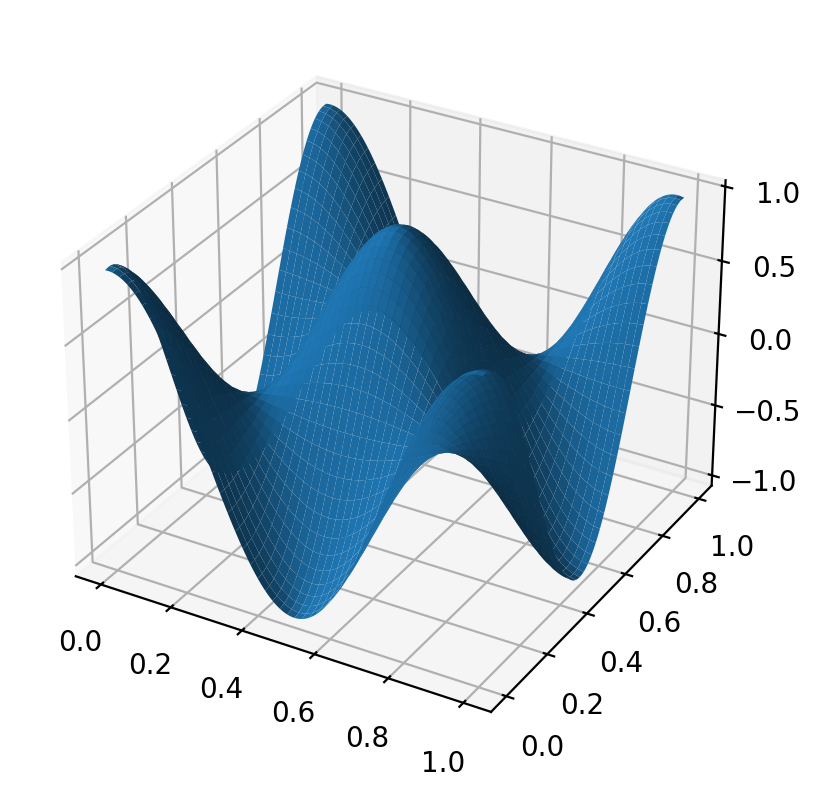

time taken:  42.711897134780884
neuron num 		 error 		 order
4 		 1.461e+00 		 * 		 6.361e+00 		 * 		 7.373e+02 		 * 

8 		 2.118e+00 		 -0.54 		 1.648e+01 		 -1.37 		 4.753e+02 		 0.63  

16 		 1.255e+00 		 0.76 		 1.087e+01 		 0.60 		 9.463e+01 		 2.33  

32 		 1.921e-01 		 2.71 		 1.543e+00 		 2.82 		 7.822e+00 		 3.60  

64 		 5.458e-02 		 1.82 		 6.424e-01 		 1.26 		 1.186e+00 		 2.72  

128 		 1.567e-02 		 1.80 		 2.025e-01 		 1.67 		 1.735e-01 		 2.77  

256 		 6.510e-03 		 1.27 		 1.056e-01 		 0.94 		 2.485e-02 		 2.80  



/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_1200/3057554446.py:184: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print("{} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f}  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_1200/3057554446.py:185: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_1200/3057554446.py:186: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list3[i] , np.log(err_list3[i-1]/err_list3[i])/np.log(2) ) )
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ip

In [ ]:
m1 = 2
m2 = 2  
def u_exact(x):
    return torch.cos(m1 * pi*x[:,0:1])*torch.cos(m2 * pi*x[:,1:2]) 

def u_exact_grad(): 
    def grad_1(x):
        return  - m1*pi* torch.sin(m1*pi*x[:,0:1])*torch.cos( m2*pi*x[:,1:2]) 
    def grad_2(x):
        return  - m2*pi* torch.cos(m1*pi*x[:,0:1])*torch.sin( m2*pi*x[:,1:2]) 

    u_grad=[grad_1, grad_2] 

    return u_grad

def rhs(x):
    z = ( (m1*pi)**2 + (m2*pi)**2 + 1)*torch.cos(m1 * pi*x[:,0:1])*torch.cos(m2  * pi*x[:,1:2] )
    return z 


dim = 2  
function_name = "cospix2d" 
filename_write = "data/2DOGA-{}-order.txt".format(function_name)
Nx = 50  
order = 2  
f_write = open(filename_write, "a")
f_write.write("Integration points: Nx {}, order {} \n".format(Nx,order))
f_write.close() 

save = False 
write2file = True
rand_deter = 'rand'
for N in [2**10]: # 2**12,2**14
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 8  
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    relu_k = 3     
    err_QMC2, err_h10, err_energy, my_model = OGANeumannPINNReLU2D(None,rhs,u_exact,u_exact_grad,u_exact, N,num_epochs,plot_freq, Nx, order, k =relu_k, rand_deter = rand_deter,solver = "direct")

    if save: 
        folder = 'data/'
        filename = folder + 'err_NeumannOGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_NeumannOGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    show_convergence_order2_PINN(err_QMC2,err_h10,err_energy, exponent,2*N,filename_write,write2file = write2file)



In [48]:
show_convergence_order2_PINN(err_QMC2,err_h10,err_energy, exponent,2*N,filename_write,write2file = write2file)
# show_convergence_order_latex2(err_QMC2,err_h10,exponent,k=relu_k,d = dim)



neuron num 		 error 		 order
4 		 3.551e-01 		 * 		 1.699e+00 		 * 		 1.196e+01 		 * 

8 		 2.454e-01 		 0.53 		 1.453e+00 		 0.23 		 5.949e+00 		 1.01  

16 		 9.482e-02 		 1.37 		 7.741e-01 		 0.91 		 1.938e+00 		 1.62  

32 		 7.799e-02 		 0.28 		 6.153e-01 		 0.33 		 7.083e-01 		 1.45  

64 		 7.251e-02 		 0.11 		 5.579e-01 		 0.14 		 2.696e-01 		 1.39  

128 		 6.025e-02 		 0.27 		 4.520e-01 		 0.30 		 1.043e-01 		 1.37  

256 		 3.880e-02 		 0.63 		 2.919e-01 		 0.63 		 3.836e-02 		 1.44  



/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_58742/3057554446.py:184: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print("{} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f} \t\t {:.3e} \t\t {:.2f}  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_58742/3057554446.py:185: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2),
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T/ipykernel_58742/3057554446.py:186: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  err_list3[i] , np.log(err_list3[i-1]/err_list3[i])/np.log(2) ) )
/var/folders/45/p1_q2drx75983lk7ph_1gx6mhpr5_w/T